# CO$_{2}$ Flux Decomposition

This is the working area to develop a script that takes time series from a given region and decomposes the CO2 flux changes from a given climate event (e.g. ENSO) into the relative components contributing to that change (U, SST, S, DIC, etc.)

To improve this script, can compute sensitivities in 5-10 year chunks to reduce error due to changing mean state.

In [1]:
import numpy as np
import pandas as pd
import xarray as xr
import matplotlib.pyplot as plt
%matplotlib inline
plt.style.use('seaborn-whitegrid')
import seaborn as sns
from esmtools.physics import stress_to_speed
from esmtools.carbon import co2_sol, schmidt
import cartopy.crs as ccrs
import cartopy.feature as cfeature
import esmtools as et

In [24]:
"""
Some constants that are pertinent for this.
"""
a = 6.972e-7 # Flux coefficient in s/m
conversion = (60 * 60 * 24 * 365) / 1e3 # Applied to every term of the expansion to have proper units (see notes)
S0 = 35 # Salinity constant

In [25]:
e = 'CalCS'
x = 'NPGO'
smooth = 12

#### Load in all important ensemble means

Will use this to compute sensitivities

In [26]:
def load_ensemble_mean(e, v):
    """
    Loads in the ensemble mean time series for a given upwelling system (e)
    and variable (v). I will use these to compute the sensitivities, which shouldn't
    cause too much error since it's a much larger value than the residuals.
    """
    filepath = ('/glade/p/work/rbrady/EBUS_BGC_Variability/' + v + '/' + e +
               '/filtered_output/' + e.lower() + '-' + v + '-forced-signal-AW-chavez-800km.nc')
    da = xr.open_dataarray(filepath)
    da.name = v
    return da

In [27]:
variables = ['FG_CO2', 'SST', 'SALT', 'DIC', 'ALK', 'TAUX',
             'TAUY', 'TAUX2', 'TAUY2', 'sDIC', 'sALK', 'U',
             'DCO2STAR', 'RHO', 'pCO2SURF']
forced = xr.Dataset()
for i, name in enumerate(variables):
    da = load_ensemble_mean(e, name)
    forced = xr.merge([forced, da])

In [28]:
forced = forced.rename({'pCO2SURF': 'pCO2'})
means = forced.mean()

#### Load in the regression results.

In [29]:
def load_regression(e, x, y, smooth):
    """
    Loads in the area-weighted regression results for a given upwelling system
    (e), predictor variable (x), and dependent variable (y). Need to add functionality
    for lagging. Currently assumes values of 0 for each of those features.
    """
    filepath = ('/glade/p/work/rbrady/EBUS_BGC_Variability/area_weighted_regional_regressions/' +
                e + '/' + y + '/' + x + '/')
    if smooth == 0:
        filename = (x + '.' + y + '.' + e + '.unsmoothed.area_weighted_regional_regression.lag0.nc')
    else:
        filename = (x + '.' + y + '.' + e + '.smoothed' + str(smooth) + '.area_weighted_regional_regression.lag0.nc')
    ds = xr.open_dataset(filepath + filename)
    return ds

In [30]:
delta_FG_CO2 = load_regression(e, x, 'FG_CO2', smooth)
delta_U = load_regression(e, x, 'U', smooth)
delta_SST = load_regression(e, x, 'SST', smooth)
delta_SALT = load_regression(e, x, 'SALT', smooth)
delta_sDIC = load_regression(e, x, 'sDIC', smooth)
delta_sALK = load_regression(e, x, 'sALK', smooth)

In [31]:
"""
tolerance = 0.1
np.where((delta_FG_CO2['p'] <= tolerance) & 
         (delta_U['p'] <= tolerance) &
         (delta_SST['p'] <= tolerance) &
         (delta_SALT['p'] <= tolerance) &
         (delta_sDIC['p'] <= tolerance) &
         (delta_sALK['p'] <= tolerance))
"""
# Seems impossible to get all 34 members to be significant in all terms. So maybe just
# test significance of FG_CO2?
tolerance = 0.1
delta_U = delta_U.where(delta_FG_CO2['p'] <= tolerance, drop=True)
delta_SST = delta_SST.where(delta_FG_CO2['p'] <= tolerance, drop=True)
delta_SALT = delta_SALT.where(delta_FG_CO2['p'] <= tolerance, drop=True)
delta_sDIC = delta_sDIC.where(delta_FG_CO2['p'] <= tolerance, drop=True)
delta_sALK = delta_sALK.where(delta_FG_CO2['p'] <= tolerance, drop=True)
delta_FG_CO2 = delta_FG_CO2.where(delta_FG_CO2['p'] <= tolerance, drop=True)
N = len(delta_FG_CO2['m'])

### Compute Terms

In [32]:
# Repetitive terms
Sc = schmidt(forced['SST'])
ff = co2_sol(forced['SST'], forced['SALT'])
gamma_DIC = (3*means['ALK']*means['DIC'] - 2*means['DIC']**2) / \
            ((2*means['DIC']-means['ALK'])*(means['ALK']-means['DIC']))
gamma_ALK = (-means['ALK']**2)/((2*means['DIC']-means['ALK'])*(means['ALK']-means['DIC']))


""" 
The conversion term converts to the proper mol/m2/yr for every unit. So that we actually have each term
summing to a mol/m2/yr perturbation from some climate event.

Can run a np.where command on the original delta datasets to drop non-significant results.
"""
# SENSITIVITIES
dFdpCO2 = means['RHO']*ff*a*np.sqrt(660/Sc)*means['U']**2
dFdU = -2*a*np.sqrt(660/Sc)*means['U']*means['DCO2STAR']
dFdSST = dFdpCO2*0.0423*means['pCO2']
dFdSALT = dFdpCO2*(means['pCO2']/means['SALT'])
dpCO2dDIC = (means['pCO2']*gamma_DIC)/means['DIC']
dpCO2dALK = (means['pCO2']*gamma_ALK)/means['ALK']

# FULL TERM
F = delta_FG_CO2['m']
U = dFdU*delta_U['m']*conversion
SST = dFdSST*delta_SST['m']*conversion
SALT = dFdSALT*delta_SALT['m']*conversion
sDIC = dFdpCO2*dpCO2dDIC*(means['SALT']/S0)*delta_sDIC['m']*conversion
sALK = dFdpCO2*dpCO2dALK*(means['SALT']/S0)*delta_sALK['m']*conversion

# Freshwater
term1 = dFdpCO2*dpCO2dDIC*(means['sDIC']/S0)*delta_SALT['m']*conversion
term2 = dFdpCO2*dpCO2dALK*(means['sALK']/S0)*delta_SALT['m']*conversion
FW = term1 + term2

### Visualize

In [33]:
def setup_dataframe(v, da):
    """
    Creates a DataFrame with term values given a variable name (v) and the
    DataArray containing the expansion results (da).
    """
    da.name = v
    df = da.to_dataframe()
    del df['z_t']
    return df

In [34]:
variables = ['U','SST','SALT','sDIC','sALK','FW']
df = pd.DataFrame()
for i, name in enumerate(variables):
    temp_df = setup_dataframe(name, eval(name))
    df = pd.concat([df, temp_df], axis=1)
df['Total'] = df.sum(axis=1)

In [35]:
# For putting the variance explained.
avg_r = delta_FG_CO2['r'].median()
avg_r = avg_r.values

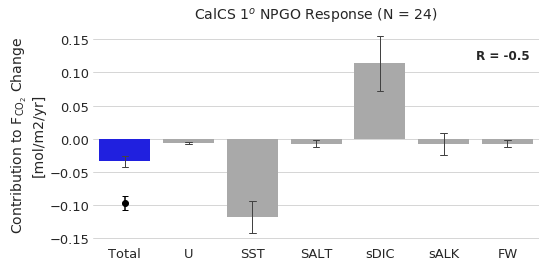

In [39]:
sns.set_style('whitegrid')
if F.mean() > 0:
    clist = ['r', '#a9a9a9', '#a9a9a9', '#a9a9a9', '#a9a9a9', '#a9a9a9', '#a9a9a9']
else:
    clist = ['b', '#a9a9a9', '#a9a9a9', '#a9a9a9', '#a9a9a9', '#a9a9a9', '#a9a9a9']
order = list(['Total', 'U', 'SST', 'SALT', 'sDIC', 'sALK', 'FW'])
f, ax = plt.subplots(figsize=(8,4))
bars = sns.barplot(data=df, ax=ax, ci='sd', capsize=0.1, errwidth=1,
                   palette=clist, order=order)
sns.despine(left=True, bottom=True)
ax.set_title(e + ' 1$^{o}$' + ' ' + x + ' Response (N = ' + str(N) + ')', fontsize=14)
ax.set_ylabel('Contribution to F$_{\mathrm{CO}_{2}}$ Change' + '\n' + '[mol/m2/yr]',
              fontsize=14)

# Add true regression
ax.errorbar(0, F.mean(), yerr=F.std(), fmt='o', capsize=3, color='k', markersize=6)

# Add variance explained.
plt.text(5.5, 0.12, 'R = ' + str(avg_r.round(2)), fontsize=12, fontweight='bold',
        bbox={'edgecolor':'w', 'facecolor':'w', 'alpha':0.2})

# Fontsizes
ax.tick_params(labelsize=13)

# Save figure.
et.vis.savefig('CalCS_NPGO_decomp')

# Signs of Sensitivity and Regression Terms

In [15]:
def mean(x):
    return x['m'].mean()

In [16]:
def color_negative_red(val):
    """
    Takes a scalar and returns a string with
    the css property `'color: red'` for negative
    strings, black otherwise.
    """
    color = 'red' if val == '-' else 'green'
    return 'color: %s' % color

In [17]:
# Set up list of terms
sens_list = np.asarray([dFdU, dFdSST, dFdSALT, (dFdpCO2*dpCO2dDIC), (dFdpCO2*dpCO2dALK)])
reg_list = np.asarray([mean(delta_U), mean(delta_SST), mean(delta_SALT), mean(delta_sDIC),
                       mean(delta_sALK)])
term_list = np.asarray([U.mean(),SST.mean(),SALT.mean(),sDIC.mean(),sALK.mean()])

In [18]:
# Replace with + and -
sens = []
reg = []
term = []
for s, r, t in zip(sens_list, reg_list, term_list):
    if s < 0:
        sens.append('-')
    else:
        sens.append('+')
    if r < 0:
        reg.append('-')
    else:
        reg.append('+')
    if t < 0:
        term.append('-')
    else:
        term.append('+')

In [19]:
df = pd.DataFrame({'Sensitivity': sens, '$\Delta$': reg, 'Term': term},
                  index=['U','SST','SALT','sDIC','sALK'])
df = df[['Sensitivity','$\Delta$','Term']]

In [20]:
s = df.style.applymap(color_negative_red)

In [21]:
means['DCO2STAR']

<xarray.DataArray 'DCO2STAR' ()>
array(0.21533966510349523)

In [22]:
s

,Sensitivity,$\Delta$,Term
U,-,+,-
SST,+,-,-
SALT,+,-,-
sDIC,+,+,+
sALK,-,+,-


# Degrees or Sigma?

In [ ]:
ds = xr.open_dataset('/glade/p/work/rbrady/cesmLE_CVDP/processed/cvdp_detrended_BGC.nc')
#ds = xr.open_mfdataset('/glade/p/work/rbrady/EBUS_BGC_Variability/NPGO/*.nc', concat_dim='ensemble')

In [ ]:
ds['nao']